In [1]:
import os
from openai import OpenAI
import time
import random


In [16]:
deepseek_client = OpenAI(
    api_key=os.environ.get("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com"
)

In [17]:
def test_prompt_deepseek(prompt, suppress=False, model='deepseek-chat', retries=10, **kwargs):
    """A simple function to take in a prompt and run it through a given non-chat model with retries."""
    
    for attempt in range(retries):
        try:
            chat_completion = deepseek_client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=model,
                **kwargs
            )
            answer = chat_completion.choices[0].message.content
            if not suppress:
                print(f'PROMPT:\n------\n{prompt}\n------\nRESPONSE (from {model})\n------\n{answer}')
            return answer
        except Exception as e:
            wait_time = 2 ** attempt + random.uniform(0, 1)  # Exponential backoff
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {wait_time:.2f} seconds...")
            time.sleep(wait_time)
    
    raise RuntimeError(f"Failed after {retries} retries.")


In [18]:
test_prompt_deepseek('1+1=', model='deepseek-reasoner')

PROMPT:
------
1+1=
------
RESPONSE (from deepseek-reasoner)
------
The result of 1 + 1 is **2**. This is a fundamental arithmetic operation where adding the quantity of 1 to another 1 yields a total of 2.


'The result of 1 + 1 is **2**. This is a fundamental arithmetic operation where adding the quantity of 1 to another 1 yields a total of 2.'

# Dynamic k shot using embeddings WITH MathQA

In [19]:
def is_num(x):
    try:
        return float(x) != None
    except:
        return False
is_num(1), is_num('true')

(True, False)

In [20]:
from datasets import load_dataset

dataset = load_dataset("math_qa")
dataset

DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 29837
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 2985
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category'],
        num_rows: 4475
    })
})

In [21]:
print(dataset['train']['Problem'][0])


the banker ' s gain of a certain sum due 3 years hence at 10 % per annum is rs . 36 . what is the present worth ?


In [22]:
dataset = dataset.map(
    lambda x: {
        'question': x['Problem'], 
        'response': x['Rationale'].split('answer ')[0], 
        'answer': x['options'].split(f'{x["correct"]} ) ')[-1].split(' ')[0]
    }
)
dataset = dataset.filter(lambda x: is_num(x['answer']))
dataset

DatasetDict({
    train: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 26318
    })
    test: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 2667
    })
    validation: Dataset({
        features: ['Problem', 'Rationale', 'options', 'correct', 'annotated_formula', 'linear_formula', 'category', 'question', 'response', 'answer'],
        num_rows: 3983
    })
})

In [23]:
dataset['test'][0]

{'Problem': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount had been offered ?',
 'Rationale': '"giving no discount to customer implies selling the product on printed price . suppose the cost price of the article is 100 . then printed price = 100 ã — ( 100 + 31.1 ) / ( 100 â ˆ ’ 5 ) = 138 hence , required % profit = 138 â € “ 100 = 38 % answer a"',
 'options': 'a ) 38 , b ) 27.675 , c ) 30 , d ) data inadequate , e ) none of these',
 'correct': 'a',
 'annotated_formula': 'subtract(divide(multiply(add(const_100, 31.1), const_100), subtract(const_100, 5)), const_100)',
 'linear_formula': 'add(n1,const_100)|subtract(const_100,n0)|multiply(#0,const_100)|divide(#2,#1)|subtract(#3,const_100)|',
 'category': 'gain',
 'question': 'a shopkeeper sold an article offering a discount of 5 % and earned a profit of 31.1 % . what would have been the percentage of profit earned if no discount ha

In [24]:
print(dataset['train']['question'][0])
print()
print(dataset['train']['response'][0])
print()
print(dataset['train']['answer'][0])

average age of students of an adult school is 40 years . 120 new students whose average age is 32 years joined the school . as a result the average age is decreased by 4 years . find the number of students of the school after joining of the new students .

"explanation : let the original no . of students be x . according to situation , 40 x + 120 * 32 = ( x + 120 ) 36 ⇒ x = 120 so , required no . of students after joining the new students = x + 120 = 240 . 

240


In [25]:
dataset = dataset.filter(lambda x: float(x['answer']) > 10000)

In [26]:
def format_k_shot(examples, cot=True):
    if cot:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nReasoning: {e["response"]}\nAnswer: {e["answer"]}' for e in examples]
        )
    else:
        return '\n###\n'.join(
            [f'Question: {e["question"]}\nAnswer: {e["answer"]}' for e in examples]
        )

In [27]:
unanswered_example = dataset['test'][0]

PROMPT = f"""Answer the question in the following format:

{format_k_shot(list(dataset['train'])[:3])}
###
Question: {unanswered_example["question"]}
Reasoning:""".strip()

print(PROMPT)

Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: in an election b

In [28]:
test_prompt_deepseek(
    PROMPT, 
    model='deepseek-chat')

PROMPT:
------
Answer the question in the following format:

Question: if the annual increase in the population of a town is 10 % and the present number of people is 10000 , what will the population be in 2 years ?
Reasoning: "the required population is = 10000 ( 1 + 10 / 100 ) ^ 2 = 10000 * 11 / 10 * 11 / 10 = 12100 
Answer: 12100
###
Question: a , b and c started a partnership business by investing rs . 12000 , rs . 16000 , rs . 20000 respectively . at the end of the year , the profit were distributed among them . if c ' s share of profit is 36000 , what is the total profit ?
Reasoning: "a : b : c = 12000 : 16000 : 20000 = 3 : 4 : 5 let total profit = p then p ã — 5 / 12 = 36000 p = ( 36000 ã — 12 ) / 5 = 86400 
Answer: 86400
###
Question: sonika deposited rs . 8000 which amounted to rs . 11200 after 3 years at simple interest . had the interest been 2 % more . she would get how much ?
Reasoning: "( 8000 * 3 * 2 ) / 100 = 480 11200 - - - - - - - - 11680 
Answer: 11680
###
Question: i

'Question: in an election between two candidates , the winner has a margin of 10 % of the votes polled . if 4000 people change their mind and vote for the loser , the loser would have won by a margin of 10 % of the votes polled . find the total number of votes polled in the election ?\n\nReasoning: Let the total number of votes polled be \\( V \\). The winner initially has a margin of 10% of the votes polled, so the winner gets \\( 0.55V \\) votes and the loser gets \\( 0.45V \\) votes. If 4000 people change their mind and vote for the loser, the new vote counts would be:\n- Winner: \\( 0.55V - 4000 \\)\n- Loser: \\( 0.45V + 4000 \\)\n\nNow, the loser would have a margin of 10% of the votes polled, so:\n\\[ (0.45V + 4000) - (0.55V - 4000) = 0.10V \\]\n\nSimplify the equation:\n\\[ 0.45V + 4000 - 0.55V + 4000 = 0.10V \\]\n\\[ -0.10V + 8000 = 0.10V \\]\n\\[ 8000 = 0.20V \\]\n\\[ V = \\frac{8000}{0.20} \\]\n\\[ V = 40000 \\]\n\nAnswer: 40000'

In [30]:
test_prompt_deepseek(
    PROMPT, 
    model='deepseek-reasoner')

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.00 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.75 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.44 seconds...
Attempt 4 failed: Expecting value: line 1 column 1 (char 0). Retrying in 8.91 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.19 seconds...
Attempt 6 failed: Expecting value: line 1 column 1 (char 0). Retrying in 32.62 seconds...
Attempt 7 failed: Expecting value: line 1 column 1 (char 0). Retrying in 64.51 seconds...
Attempt 8 failed: Expecting value: line 1 column 1 (char 0). Retrying in 128.56 seconds...


KeyboardInterrupt: 

In [93]:
from sentence_transformers import SentenceTransformer

emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

docs = dataset['train']['question']
doc_emb = emb_model.encode(docs, batch_size=32, show_progress_bar=True)

doc_emb.shape  #  == (n, 768)


/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

(690, 768)

In [94]:
from random import sample
from sentence_transformers import util

query = dataset['test']['question'][0]
print(query)


in an election between two candidates , the winner has a margin of 10 % of the votes polled . if 4000 people change their mind and vote for the loser , the loser would have won by a margin of 10 % of the votes polled . find the total number of votes polled in the election ?


In [151]:
MODELS = ['deepseek-chat', 'deepseek-reasoner']

In [113]:
retries = 5

In [114]:
import re
import numpy as np
import random

def extract_num(string):
    pattern = r'[\d,]+'
    match = re.search(pattern, string)
    if match:
        number_str = match.group()
        try:
            number = float(number_str.replace(',', ''))
            return number
        except:
            return -1
    return -1
     
def test_k_shot(
    k, datapoint, verbose=False, how='closest', cot=True, options=MODELS
):
    results = {}
    
    prompt_elements = ['Answer the question in the following format:']
    if cot:
        prompt_elements.append('Question: (a question)\nReasoning: (thinking through step by step on how to solve the problem)\nAnswer: (the final answer as a number)')
    else:
        prompt_elements.append('Question: (a question)\nAnswer: (the final answer as a number)')
    
    if k > 0:
        if how == 'closest':
            query_emb = emb_model.encode(str(datapoint['question']))
            scores = util.dot_score(query_emb, doc_emb)[0].cpu().tolist()
            # Retrieve the corresponding examples from the dataset
            examples = [dataset['train'][int(_)] for _ in np.argsort(scores)[-k:][::-1]]
        else:
            examples = random.sample(list(dataset['train']), k)
        
        prompt_elements.append(format_k_shot(examples, cot=cot))
    
    if cot:
        prompt_elements.append(f'Question: {datapoint["question"]}\nReasoning:')
    else:
        prompt_elements.append(f'Question: {datapoint["question"]}\nAnswer:')
        
    
    PROMPT = '\n\n'.join(prompt_elements)
    
    if verbose:
        print(f'PROMPT\n-----\n{PROMPT}\n-----')

    
    if 'deepseek-chat' in options:
        response = test_prompt_deepseek(PROMPT, model='deepseek-chat', temperature=0, suppress=True, retries=retries)
        results['deepseek-chat'] = {'num': extract_num(response.split('Answer: ')[-1]), 'response': response, 'question': datapoint['question']}
    if 'deepseek-reasoner' in options:
        response = test_prompt_deepseek(PROMPT, model='deepseek-reasoner', temperature=0, suppress=True, retries=retries)
        results['deepseek-reasoner'] = {'num': extract_num(response.split('Answer: ')[-1]), 'response': response, 'question': datapoint['question']}
    
    results['answer'] = extract_num(datapoint['answer'])
    
    return results

In [115]:
datapoint = dataset['test'][1]
test_k_shot(0, datapoint, verbose=True, cot=False)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Answer:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nAnswer: 11988',
  'question': 'what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )'},
 'answer': 11988.0}

In [116]:
test_k_shot(0, datapoint, verbose=True, cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nReasoning:\n1. **Identify the total number of 3-digit integers**: Since repetition is allowed and there are 3 digits (3, 4, 5), the total number of 3-digit integers is \\(3 \\times 3 \\times 3 = 27\\).\n\n2. **Understand the contribution of each digit position**: Each digit (3, 4, 5) will appear equally often in each place (hundreds, tens, and units). Since there are 27 numbers, each digit will appear \\(27 / 3 = 9\\) times in each place.\n\n3. **Calculate the sum for each place**:\n   - **Hundreds place**: Each digit (3, 4, 5) appears 9 times, so the sum for the hundreds place is \\(9 \\times (3 + 4 + 5) \\times 100 = 9 \\times 12 \\times 100 = 10,800\\).\n   - **Tens place**: Similarly, the sum for the tens place is \\(9 \\times (3 + 4 + 5) \\times 10 = 9 \\times 12 \\times 10 = 1,080\\).\n   - **Units place**: The sum for

In [117]:
test_k_shot(1, datapoint, verbose=True, how='random', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: population is 20000 . pop increases by 10 % every year , then the pop after 3 years is ?
Reasoning: population after 1 st year = 20000 * 10 / 100 = 2000 = = = > 20000 + 2000 = 22000 population after 2 nd year = 22000 * 10 / 100 = 2200 = = = > 22000 + 2200 = 24200 population after 3 rd year = 24200 * 10 / 100 = 2420 = = = > 24200 + 2420 = 26620 
Answer: 26620

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nReasoning:  \n1. First, determine all possible 3-digit numbers that can be formed using the digits 3, 4, and 5 with repetition allowed.  \n   - Each digit (hundreds, tens, and units place) can be 3, 4, or 5.  \n   - Total number of combinations = 3 × 3 × 3 = 27.  \n\n2. For each place (hundreds, tens, and units), each digit (3, 4, 5) will appear equally often.  \n   - Since there are 27 numbers, each digit will appear 27 / 3 = 9 times in each place.  \n\n3. Calculate the contribution of each place to the total sum:  \n   - Hundreds place: (3 + 4 + 5) × 9 × 100 = 12 × 9 × 100 = 10,800  \n   - Tens place: (3 + 4 + 5) × 9 × 10 = 12 × 9 × 10 = 1,080  \n   - Units place: (3 + 4 + 5) × 9 × 1 = 12 × 9 × 1 = 108  \n\n4. Add the contributions from all places to get the total sum:  \n   - Total sum = 10,800 + 1,080 + 108 = 11,988  \n\

In [118]:
test_k_shot(1, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456

Question: what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )
Reasoning:
-----


{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: What is the sum of all 3-digit integers formed using the digits 3, 4, and 5 (repetition is allowed)?\n\nReasoning:  \n1. **Total number of 3-digit integers**: Since repetition is allowed and there are 3 digits (3, 4, 5), the total number of 3-digit integers is \\( 3 \\times 3 \\times 3 = 27 \\).\n\n2. **Average value of the integers**: The smallest 3-digit integer formed is 333, and the largest is 555. The average value is calculated as:  \n   \\[\n   \\text{Average} = \\frac{333 + 555}{2} = \\frac{888}{2} = 444\n   \\]\n\n3. **Sum of all integers**: Multiply the total number of integers by the average value:  \n   \\[\n   \\text{Sum} = 27 \\times 444 = 11988\n   \\]\n\nAnswer: 11988',
  'question': 'what is the sum of all 3 digit integers formed using the digits 34 and 5 ( repetition is allowed )'},
 'answer': 11988.0}

In [119]:
test_k_shot(3, datapoint, verbose=True, how='closest', cot=True)

PROMPT
-----
Answer the question in the following format:

Question: (a question)
Reasoning: (thinking through step by step on how to solve the problem)
Answer: (the final answer as a number)

Question: what is the sum of all 4 digit integers formed using the digits 2 , 3 , 4 and 5 ( repetition is allowed )
Reasoning: n = 4 * 4 * 4 * 4 = 256 < x > = ( 5555 + 2222 ) / 2 = 3888.5 sum = number of integers x average value n * < x > = 256 * 3888.5 = 711040 
Answer: 995456
###
Question: find the sum of all 4 digit numbers formed using digits 1,2 , 5,6 .
Reasoning: "( n - 1 ) ! * ( 111 . . . n ) * ( sum of the digits ) = ( 4 - 1 ) ! * 1111 * ( 1 + 2 + 5 + 6 ) = 93324 
Answer: 93324
###
Question: what is the sum of all 3 digit nos formed by { 1 , 3,5 , 7,9 } with nos not repeated
Reasoning: "here 3 digit no . can be formed in 5 * 4 * 3 = 60 . thus we hv to find the sum of 60 nos . now 60 / 5 = 12 ; we hv 12 no ' s . starting with 1 , 12 no ' s . with 3,5 , 7,9 . . . . so 12 * 100 * ( 1 + 3 + 5

{'deepseek-chat': {'num': 11988.0,
  'response': 'Question: what is the sum of all 3 digit integers formed using the digits 3, 4, and 5 (repetition is allowed)  \nReasoning:  \n1. The number of 3-digit integers formed using the digits 3, 4, and 5 with repetition allowed is \\(3 \\times 3 \\times 3 = 27\\).  \n2. Each digit (3, 4, 5) appears equally often in each place (hundreds, tens, units). Since there are 27 numbers, each digit appears \\(27 / 3 = 9\\) times in each place.  \n3. The sum of the digits is \\(3 + 4 + 5 = 12\\).  \n4. The contribution of each place (hundreds, tens, units) to the total sum is \\(9 \\times 12 \\times \\text{place value}\\).  \n   - For hundreds place: \\(9 \\times 12 \\times 100 = 10800\\).  \n   - For tens place: \\(9 \\times 12 \\times 10 = 1080\\).  \n   - For units place: \\(9 \\times 12 \\times 1 = 108\\).  \n5. The total sum is \\(10800 + 1080 + 108 = 11988\\).  \n\nAnswer: 11988',
  'question': 'what is the sum of all 3 digit integers formed using 

In [120]:
t, batch_size = 2, 10  # time to wait in seconds, batch size

In [121]:
import numpy as np
import random

random.seed(42)

dataset_sample = random.sample(list(dataset['test']), 50)

In [122]:
len(dataset_sample)

50

In [123]:
dataset_sample[0]

{'Problem': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'Rationale': '"3 ^ 8 * ( 2 ) = 13122 the answer is c"',
 'options': 'a ) 512 , b ) 768 , c ) 13122 , d ) 2048 , e ) 4096',
 'correct': 'c',
 'annotated_formula': 'subtract(power(3, add(8, const_1)), const_1)',
 'linear_formula': 'add(n0,const_1)|power(n1,#0)|subtract(#1,const_1)|',
 'category': 'physics',
 'question': 'the population of a bacteria colony doubles every day . if it was started 8 days ago with 3 bacteria and each bacteria lives for 12 days , how large is the colony today ?',
 'response': '"3 ^ 8 * ( 2 ) = 13122 the ',
 'answer': '13122'}

In [124]:
import time

In [125]:
results = {}

# Just Ask (K=0) with and without CoT

In [126]:
import concurrent.futures
from tqdm import tqdm
import time

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None
k = 0
results['Just Ask (K=0 with CoT)'] = []
results['Just Ask (K=0 no CoT)'] = []

def process_batch(futures, result_list, pbar):
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            result_list.append(result)
        pbar.update(1)

with concurrent.futures.ThreadPoolExecutor() as executor:
    total_batches = (len(dataset_sample) // batch_size) * 2
    with tqdm(total=total_batches) as pbar:
        for i in range(0, len(dataset_sample), batch_size):
            time.sleep(t)
            batch_futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True) for gsm in dataset_sample[i:i+batch_size]]
            batch_futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False) for gsm in dataset_sample[i:i+batch_size]]
            
            process_batch(batch_futures_with_cot, results['Just Ask (K=0 with CoT)'], pbar)
            process_batch(batch_futures_no_cot, results['Just Ask (K=0 no CoT)'], pbar)

100it [06:13,  3.74s/it]                                                                                                                               


# Semantic k-shot prompting for K=1, 3, 5 with and without CoT

In [127]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='closest', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. K={k}')
        return None

def process_batch(executor, batch, k, cot, result_list, description):
    futures = [executor.submit(test_k_shot_parallel, k, gsm, cot) for gsm in batch]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Semantic K={k} (with CoT)'] = []
    results[f'Semantic K={k} (no CoT)'] = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]
            process_batch(executor, batch, k, True, results[f'Semantic K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(executor, batch, k, False, results[f'Semantic K={k} (no CoT)'], f"K={k} no CoT")


Batches for K=1:   0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

K=1 with CoT:   0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

K=1 with CoT:  10%|██████████                                                                                           | 1/10 [00:06<01:02,  6.97s/it]

K=1 with CoT:  20%|████████████████████▏                                                                                | 2/10 [00:07<00:25,  3.13s/it]

K=1 with CoT:  30%|██████████████████████████████▎                                                                      | 3/10 [00:17<00:45,  6.52s/it]

K=1 with CoT:  40%|████████████████████████████████████████▍                                                            | 4/10 [00:23<00:37,  6.30s/it]

K=1 with CoT:  60%|████████████████████████████████████████████████████████████▌  

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.08 seconds...




K=1 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  8.20s/it]

                                                                                                                                                       

K=1 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

K=1 no CoT:  10%|██████████▎                                                                                            | 1/10 [00:13<01:57, 13.05s/it]

K=1 no CoT:  20%|████████████████████▌                                                                                  | 2/10 [00:15<00:52,  6.53s/it]

K=1 no CoT:  30%|██████████████████████████████▉                                                                        | 3/10 [00:19<00:37,  5.40s/it]

K=1 no CoT:  40%|█████████████████████████████████████████▏                     

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.29 seconds...




K=1 no CoT: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00, 10.16s/it]

                                                                                                                                                       
Batches for K=1:  40%|███████████████████████████████████████▏                                                          | 2/5 [05:33<08:15, 165.06s/it]

K=1 with CoT:   0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

K=1 with CoT:  10%|██████████                                                                                           | 1/10 [00:09<01:25,  9.54s/it]

K=1 with CoT:  20%|████████████████████▏                                                                                | 2/10 [00:18<01:13,  9.15s/it]

K=1 with CoT:  30%|██████████████████████████████▎                               

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.63 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.89 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.36 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.19 seconds...




K=1 with CoT:  60%|████████████████████████████████████████████████████████████▌                                        | 6/10 [01:05<00:44, 11.03s/it]

K=1 with CoT:  70%|██████████████████████████████████████████████████████████████████████▋                              | 7/10 [01:18<00:34, 11.56s/it]

K=1 with CoT:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [01:20<00:16,  8.36s/it]

K=1 with CoT:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [01:27<00:08,  8.15s/it]

K=1 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:29<00:00,  6.24s/it]

                                                                                                                                                       

K=1 no CoT:   0%|                                                               

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.07 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.66 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.77 seconds...




K=1 with CoT:  70%|██████████████████████████████████████████████████████████████████████▋                              | 7/10 [01:03<00:20,  6.73s/it]

K=1 with CoT:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [01:14<00:16,  8.17s/it]

K=1 with CoT:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [01:24<00:08,  8.87s/it]

K=1 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  8.90s/it]

                                                                                                                                                       

K=1 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

K=1 no CoT:  10%|██████████▎                                                    

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.99 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.86 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.87 seconds...




K=3 with CoT:  70%|██████████████████████████████████████████████████████████████████████▋                              | 7/10 [01:01<00:23,  7.98s/it]

K=3 with CoT:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [01:13<00:18,  9.09s/it]

K=3 with CoT:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [01:17<00:07,  7.72s/it]

K=3 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  7.38s/it]

                                                                                                                                                       

K=3 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

K=3 no CoT:  10%|██████████▎                                                    

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.38 seconds...




K=3 with CoT:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [01:02<00:05,  5.93s/it]

K=3 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:34<00:00, 14.10s/it]

                                                                                                                                                       

K=3 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

K=3 no CoT:  10%|██████████▎                                                                                            | 1/10 [00:06<01:01,  6.81s/it]

K=3 no CoT:  20%|████████████████████▌                                                                                  | 2/10 [00:11<00:42,  5.33s/it]

K=3 no CoT:  30%|██████████████████████████████▉                                

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.45 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.83 seconds...




K=3 with CoT:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [01:07<00:23, 11.74s/it]

K=3 with CoT:  90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [01:16<00:10, 10.66s/it]

K=3 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:22<00:00,  9.38s/it]

                                                                                                                                                       

K=3 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

K=3 no CoT:  10%|██████████▎                                                                                            | 1/10 [00:04<00:39,  4.35s/it]

K=3 no CoT:  20%|████████████████████▌                                          

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.16 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.36 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.67 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.70 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.68 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.07 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.63 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.53 seconds...




K=3 no CoT:  30%|██████████████████████████████▉                                                                        | 3/10 [01:17<03:25, 29.38s/it]

K=3 no CoT:  40%|█████████████████████████████████████████▏                                                             | 4/10 [01:22<01:56, 19.49s/it]

Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.24 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.46 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.27 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.93 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.69 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.22 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.32 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.77 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.06 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.82 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.81 seconds...
Attempt 3 failed: Exp



K=3 no CoT:  50%|███████████████████████████████████████████████████                                                   | 5/10 [05:35<08:39, 103.83s/it]

Error: 1. Failed after 5 retries.. K=3




K=3 no CoT:  60%|█████████████████████████████████████████████████████████████▊                                         | 6/10 [05:35<04:34, 68.62s/it]

Error: 2. Failed after 5 retries.. K=3
Error: 3. Failed after 5 retries.. K=3




K=3 no CoT:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 8/10 [05:36<01:09, 34.89s/it]

Error: 4. Failed after 5 retries.. K=3




K=3 no CoT:  90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 9/10 [05:36<00:25, 25.97s/it]

K=3 no CoT: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:37<00:00, 18.97s/it]

                                                                                                                                                       
Batches for K=3:  80%|██████████████████████████████████████████████████████████████████████████████▍                   | 4/5 [13:33<04:02, 242.15s/it]

Error: 5. Failed after 5 retries.. K=3
Error: 6. Failed after 5 retries.. K=3




K=3 with CoT:   0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.75 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.43 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.58 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.36 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.00 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.14 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.49 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.76 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.86 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.15 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.16 seconds...
Attempt 2 failed: Exp



K=3 with CoT:  10%|██████████                                                                                          | 1/10 [05:36<50:27, 336.43s/it]

Error: 7. Failed after 5 retries.. K=3
Error: 8. Failed after 5 retries.. K=3
Error: 9. Failed after 5 retries.. K=3




K=3 with CoT:  40%|████████████████████████████████████████▍                                                            | 4/10 [05:36<06:22, 63.70s/it]

Error: 10. Failed after 5 retries.. K=3
Error: 11. Failed after 5 retries.. K=3
Error: 12. Failed after 5 retries.. K=3




K=3 with CoT:  70%|██████████████████████████████████████████████████████████████████████▋                              | 7/10 [05:37<01:28, 29.61s/it]

Error: 13. Failed after 5 retries.. K=3




K=3 with CoT:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [05:46<00:50, 25.41s/it]

Error: 14. Failed after 5 retries.. K=3
Error: 15. Failed after 5 retries.. K=3
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.24 seconds...




K=3 with CoT: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:40<00:00, 25.98s/it]

                                                                                                                                                       

Error: 16. Failed after 5 retries.. K=3




K=3 no CoT:   0%|                                                                                                               | 0/10 [00:00<?, ?it/s]

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.24 seconds...Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.57 seconds...

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.08 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.73 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.82 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.98 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.53 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.13 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.66 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.95 seconds...
Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.17 seconds...
Attempt 2 failed: Exp

Attempt 2 failed: Expecting value: line 1 column 1 (char 0). Retrying in 2.67 seconds...


K-values:  50%|████████████████████████████████████████████████████                                                    | 1/2 [34:25<34:25, 2065.39s/it]


KeyboardInterrupt: 

Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.23 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.22 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.07 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.63 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.23 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.91 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.86 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.07 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.24 seconds...
Attempt 3 failed: Expecting value: line 1 column 1 (char 0). Retrying in 4.67 seconds...
Attempt 4 failed: Expecting value: line 1 column 1 (char 0). Retrying in 8.73 seconds...
Attempt 4 failed: Exp

# Random k-shot prompting for K=1, 3 with and without CoT

In [141]:
import concurrent.futures
from tqdm import tqdm

error = 0

def test_k_shot_parallel(k, gsm, cot, i):
    global error
    try:
        return test_k_shot(k, gsm, verbose=False, how='random', cot=cot)
    except Exception as e:
        error += 1
        print(f'Error: {error}. {e}. i={i}. K={k}')
        return None

def process_batch(futures, result_list, description):
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc=description, leave=False):
        result = future.result()
        if result is not None:
            result_list.append(result)

k_values = [1, 3]
total_batches = len(dataset_sample) // batch_size + (1 if len(dataset_sample) % batch_size != 0 else 0)

for k in tqdm(k_values, desc="K-values"):
    results[f'Random K={k} (with CoT)'] = []
    results[f'Random K={k} (no CoT)'] = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i in tqdm(range(0, len(dataset_sample), batch_size), desc=f"Batches for K={k}", total=total_batches, leave=False):
            time.sleep(t)
            batch = dataset_sample[i:i+batch_size]
            
            futures_with_cot = [executor.submit(test_k_shot_parallel, k, gsm, True, i+j) for j, gsm in enumerate(batch)]
            futures_no_cot = [executor.submit(test_k_shot_parallel, k, gsm, False, i+j) for j, gsm in enumerate(batch)]
            
            process_batch(futures_with_cot, results[f'Random K={k} (with CoT)'], f"K={k} with CoT")
            process_batch(futures_no_cot, results[f'Random K={k} (no CoT)'], f"K={k} no CoT")


Batches for K=1:   0%|                                                                                                           | 0/5 [00:00<?, ?it/s]

K=1 with CoT:   0%|                                                                                                             | 0/10 [00:00<?, ?it/s]

Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.57 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.47 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.44 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.18 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.05 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.94 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.48 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.82 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.40 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.07 seconds...
Attempt 1 failed: Expecting value: line 1 column 1 (char 0). Retrying in 1.63 seconds...
Attempt 1 failed: Exp



                                                                                                                                                       
K-values:   0%|                                                                                                                  | 0/2 [04:44<?, ?it/s]


KeyboardInterrupt: 

Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.63 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.66 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.93 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.43 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.54 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.65 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.91 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.83 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.07 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.17 seconds...
Attempt 5 failed: Expecting value: line 1 column 1 (char 0). Retrying in 16.31 seconds...
Attempt 5 

In [139]:
# Open a file for writing
import json
with open('results.json', 'w') as f:
    # Write the dictionary to the file as a JSON string
    json.dump(results, f)

In [140]:
for k, values in results.items():
    print(k, len(values))

Just Ask (K=0 with CoT) 50
Just Ask (K=0 no CoT) 50
Semantic K=1 (with CoT) 50
Semantic K=1 (no CoT) 50
Semantic K=3 (with CoT) 40
Semantic K=3 (no CoT) 34
Random K=1 (with CoT) 0
Random K=1 (no CoT) 0


In [131]:
retry_dict = {}

for sample_i, sample in enumerate(dataset_sample):
    for experiment, experiment_results in results.items():
        for model in MODELS:
            model_needs_retry = True  # Assume retry is needed unless explicitly found
            
            for experiment_result in experiment_results:
                if model in experiment_result:
                    
                    if 'question' in experiment_result[model] and experiment_result[model]['question'] == sample['question']:
                        model_needs_retry = False
                        break
            
            if model_needs_retry:
                if model not in retry_dict:
                    retry_dict[model] = {}
                if experiment not in retry_dict[model]:
                    retry_dict[model][experiment] = []
                retry_dict[model][experiment].append(sample_i)

print(retry_dict)


for model in retry_dict.keys():
    print({k: len(v) for k, v in retry_dict[model].items()})


{'deepseek-chat': {'Random K=1 (with CoT)': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'Random K=1 (no CoT)': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'Semantic K=3 (no CoT)': [32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'Semantic K=3 (with CoT)': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]}}
{'Random K=1 (with CoT)': 50, 'Random K=1 (no CoT)': 50, 'Semantic K=3 (no CoT)': 16, 'Semantic K=3 (with CoT)': 10}


In [132]:
import re

for model, experiments in retry_dict.items():
    for experiment, sample_indices in experiments.items():
        cot = 'with cot' in experiment.lower()
        k_match = re.search(r'K=(\d+)', experiment)
        k = int(k_match.group(1)) if k_match else 0
        how = 'closest' if 'semantic' in experiment.lower() else 'random'
        
        for sample_i in sample_indices:
            sample = dataset_sample[sample_i]
            print(f"Running test_k_shot for Model={model}, Experiment={experiment}, DataPoint={sample_i}, k={k}, cot={cot}, how={how}")
            try:
                result = test_k_shot(k=k, datapoint=sample, verbose=False, cot=cot, how=how, options=[model])
                result['num'] = extract_num(result[model]['response'].split('Answer: ')[-1])
                result['answer'] = extract_num(sample['answer'])
                
                # Ensure the results structure is maintained
                if experiment not in results:
                    results[experiment] = []
                
                results[experiment].append(result)
            except Exception as e:
                print(e)


Running test_k_shot for Model=deepseek-chat, Experiment=Random K=1 (with CoT), DataPoint=0, k=1, cot=True, how=random


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x102ad1310>>
Traceback (most recent call last):
  File "/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "/Users/sinanozdemir/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 790, in <setcomp>
    active_threads = {thread.ident for thread in threading.enumerate()}
KeyboardInterrupt: 


KeyboardInterrupt: 

In [143]:
accuracy = {}
for k, values in results.items():
    if not values:
        continue
    accuracy[k] = {v: 0 for v in values[0].keys() if v != 'answer'}
    for d in values:
        for model_name in accuracy[k].keys():
            accuracy[k][model_name] += (1 if d[model_name]['num'] == d['answer'] else 0)
    for model_name in accuracy[k].keys():
        accuracy[k][model_name] /= len(values)
print(json.dumps(accuracy, indent=2)) 

{
  "Just Ask (K=0 with CoT)": {
    "deepseek-reasoner": 0.82,
    "deepseek-chat": 0.72
  },
  "Just Ask (K=0 no CoT)": {
    "deepseek-reasoner": 0.82,
    "deepseek-chat": 0.58
  },
  "Semantic K=1 (with CoT)": {
    "deepseek-reasoner": 0.86,
    "deepseek-chat": 0.82
  },
  "Semantic K=1 (no CoT)": {
    "deepseek-reasoner": 0.86,
    "deepseek-chat": 0.7
  },
  "Semantic K=3 (with CoT)": {
    "deepseek-reasoner": 0.88,
    "deepseek-chat": 0.84
  },
  "Semantic K=3 (no CoT)": {
    "deepseek-reasoner": 0.88,
    "deepseek-chat": 0.78
  },
  "Random K=1 (with CoT)": {
    "deepseek-reasoner": 0.8,
    "deepseek-chat": 0.78
  },
  "Random K=1 (no CoT)": {
    "deepseek-reasoner": 0.82,
    "deepseek-chat": 0.56
  },
  "Random K=3 (with CoT)": {
    "deepseek-reasoner": 0.84,
    "deepseek-chat": 0.76
  },
  "Random K=3 (no CoT)": {
    "deepseek-reasoner": 0.84,
    "deepseek-chat": 0.58
  }
}


In [144]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [157]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define pastel colors and hatch patterns for each technique
technique_styles = {
    "Just Ask (K=0 with CoT)": ('#AEC6CF', '/'),
    "Just Ask (K=0 no CoT)": ('#77DD77', '\\'),
    "Semantic K=1 (with CoT)": ('#FFB347', '+'),
    "Semantic K=1 (no CoT)": ('#CFCFC4', 'x'),
    "Semantic K=3 (with CoT)": ('#F49AC2', 'o'),
    "Semantic K=3 (no CoT)": ('#FFD1DC', 'O'),
    "Random K=1 (with CoT)": ('#B39EB5', '.'),
    "Random K=1 (no CoT)": ('#FF6961', '*'),
    "Random K=3 (with CoT)": ('#CB99C9', '-'),
    "Random K=3 (no CoT)": ('#FDFD96', '|')
}


def plot_results(title, filter=None, cot=None, filter_labels=None, labels = MODELS):
    if filter_labels:
        labels = [l for l in MODELS if any(f in l for f in filter_labels)]
    k_values = list(accuracy.keys())
    if filter:
        k_values = [_ for _ in k_values if any(f in _ for f in filter)]
    if cot is not None:
        if cot:
            k_values = [_ for _ in k_values if 'with CoT' in _]
        else:
            k_values = [_ for _ in k_values if 'no CoT' in _]
            
    sorted_k_values = sorted(k_values)
    sorted_accuracy = {label: [accuracy[k][label] for k in sorted_k_values] for label in labels}
    
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better visibility
    
    bar_width = 0.15
    num_variants = len(sorted_k_values)
    
    for i, k in enumerate(sorted_k_values):
        variant_values = [sorted_accuracy[label][i] for label in labels]
        x = np.arange(len(labels)) + (i * bar_width)
        color, hatch = technique_styles[k]
        bars = ax.bar(x, variant_values, bar_width, label=k, alpha=0.8, color=color, hatch=hatch)
    
    ax.set_ylabel('Accuracy on test set', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(np.arange(len(labels)) + (bar_width * (num_variants - 1) / 2))
    ax.set_xticklabels(labels, fontsize=12, rotation=0)
    ax.set_ylim(0, 1.)  # Set y-limit from 0 to 0.8

    # Create custom legend
    legend_handles = [
        Patch(facecolor=technique_styles[k][0], hatch=technique_styles[k][1], label=k) for k in technique_styles.keys() if k in k_values
    ]
    ax.legend(
        handles=legend_handles, title="Legend", loc='upper center',
        bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3
    )

    plt.tight_layout()
    plt.savefig(title+'.png', dpi=1000, bbox_inches='tight')  # Save with higher DPI for better quality
    plt.show()

# Does Prompting make a Difference? YES YES YES

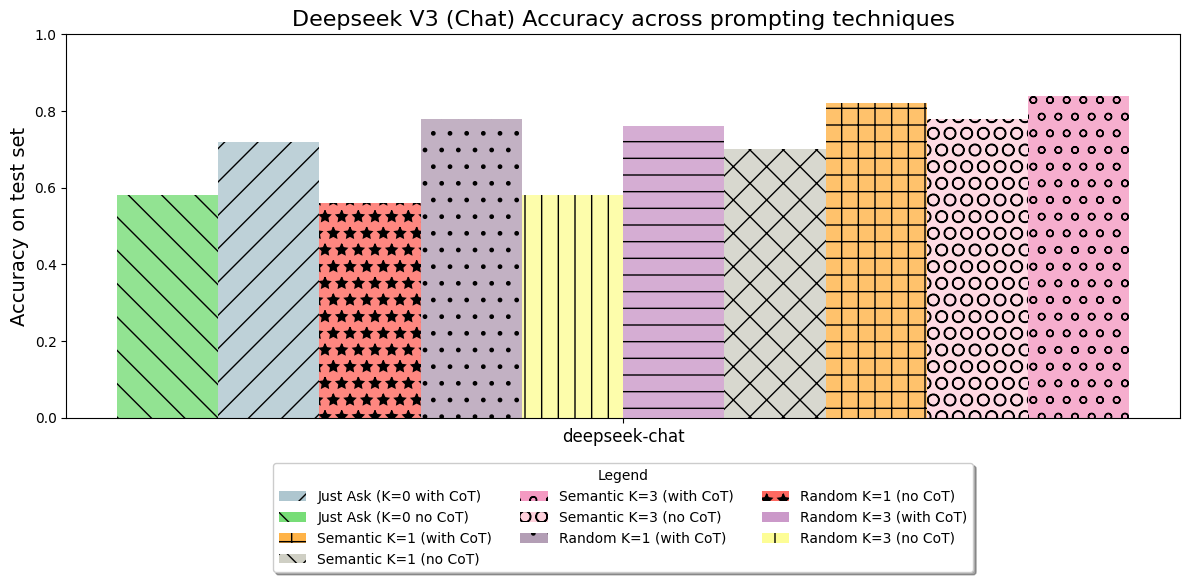

In [158]:
plot_results('Deepseek V3 (Chat) Accuracy across prompting techniques', filter_labels=['deepseek-chat'])

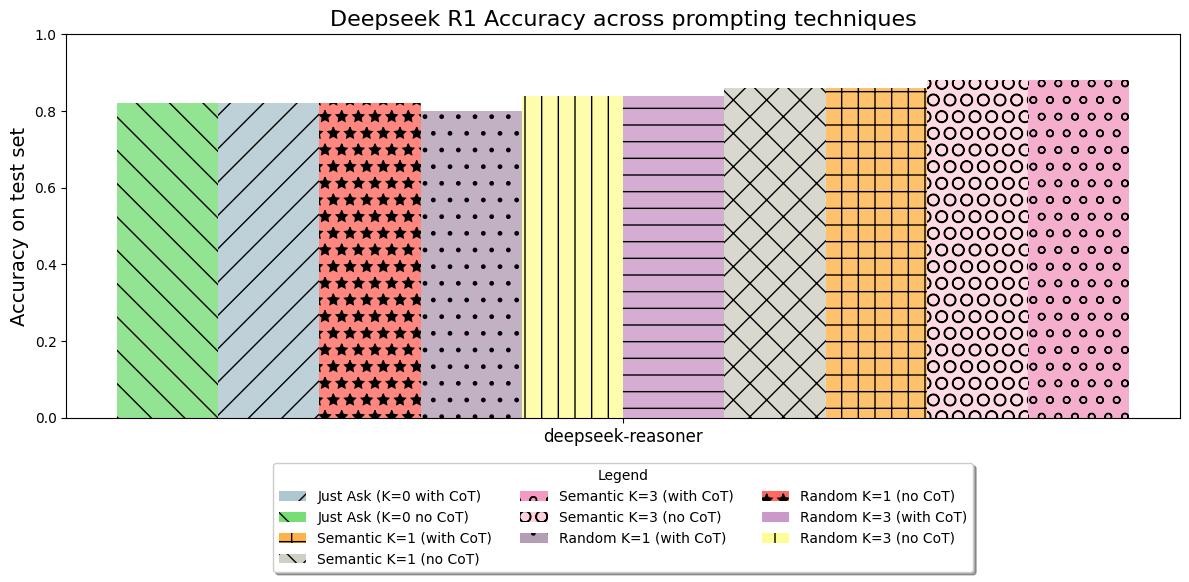

In [159]:
plot_results('Deepseek R1 Accuracy across prompting techniques', filter_labels=['deepseek-reasoner'])